In [16]:

# main 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from PIL import Image
import os 
# sklearn ----preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer   
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn_features.transformers import DataFrameSelector
#sklearn ----model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#sklearn ----metrics
from sklearn.metrics import f1_score,confusion_matrix

In [17]:
df=pd.read_csv('dataset.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [18]:
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

In [19]:
# Flitering using age feature using threshold value 80 
df.drop(index=df[df['Age']>80].index.tolist(),inplace=True)

In [20]:
#To feature anf target
X=df.drop('Exited',axis=1)
y=df['Exited']
# split to train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)


In [21]:
#Slice the lists of numerical and categorical features
num_cols=['CreditScore','Age','Balance','EstimatedSalary']
cat_cols=['Geography','Gender']
ready_cols=list(set(X_train.columns.tolist())-set(num_cols)-set(cat_cols))

In [22]:
num_pipeline=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),   
    ('scaler',StandardScaler()) 
])
cat_pipeline=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])
ready_pipeline=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')) ])
all_pipeline=ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_cols),  
    ('cat_pipeline',cat_pipeline,cat_cols),
    ('ready_pipeline',ready_pipeline,ready_cols)
])
X_train_prepared=all_pipeline.fit_transform(X_train)
X_test_prepared=all_pipeline.transform(X_test)

In [23]:
## 1. use alogrithm without taking the effect of imbalance data


In [24]:
## 2-prepare class_weight for solving inbalance data
no_bin_class=1-np.bincount(y_train)/X_train.shape[0]
class_weight={0:no_bin_class[0],1:no_bin_class[1]}


In [25]:
# 3- use smote to solve imbalance data
smote=SMOTE(random_state=42)
X_train_resmapled,y_train_resampled=smote.fit_resample(X_train_prepared,y_train)


In [26]:
with open('metrix.txt','w') as f:
     pass
def train_model(xtrain,ytrain,plot_name='',class_weight=None):
    global clf_name
    clf=RandomForestClassifier(n_estimators=300,max_depth=15,random_state=42,criterion='gini',class_weight=class_weight)
    clf.fit(xtrain,ytrain)
    ypred=clf.predict(X_test_prepared)
    score_test=f1_score(y_test,ypred)
    ypred_train=clf.predict(xtrain)
    score_train=f1_score(ytrain,ypred_train)
    clf_name=clf.__class__.__name__
    #plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test,ypred),annot=True,fmt='d',cmap='Blues')
    plt.title(f'{plot_name}')
    plt.xticks(ticks=np.arange(2)+0.5,labels=[False,True])
    plt.yticks(ticks=np.arange(2)+0.5,labels=[False,True])
    ## save plot
    plt.savefig(f'{plot_name}.png',bbox_inches='tight',dpi=300)
    plt.close()
    with open('metrix.txt','a') as f:
        f.write(f'Model name: {clf_name}\n')
        f.write(f'Train f1_score: {score_train}\n')
        f.write(f'Test f1_score: {score_test}\n')
        f.write('----------'*2+'\n')
        

In [27]:
train_model(X_train_prepared,y_train,plot_name='Without handling imbalance data')

In [28]:
train_model(X_train_prepared,y_train,plot_name='With-class-weight',class_weight=class_weight)

In [29]:
## 3. with considering the imabalancing data using oversampled data (SMOTE)
train_model(xtrain=X_train_resmapled, ytrain=y_train_resampled, plot_name=f'with-SMOTE', class_weight=None)

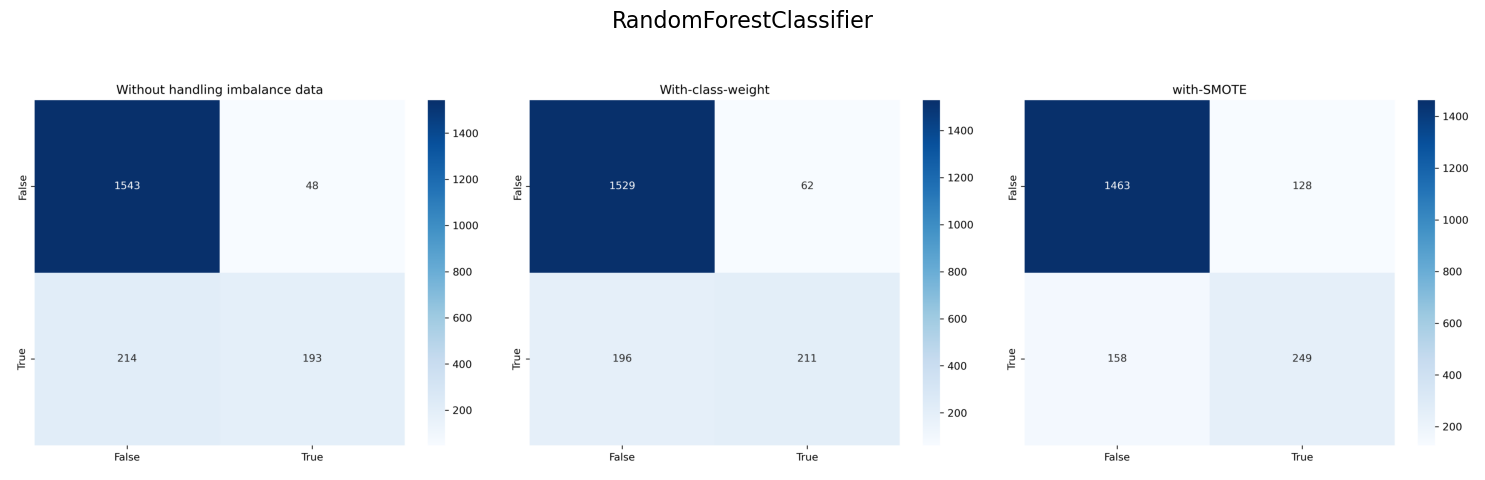

In [30]:
confusion_matrix_paths=[f'./Without handling imbalance data.png',
                        f'./With-class-weight.png',
                            f'./with-SMOTE.png']
plt.figure(figsize=(15, 5))  # Adjust figure size as needed
for i, path in enumerate(confusion_matrix_paths, 1):
    img = Image.open(path)
    plt.subplot(1, len(confusion_matrix_paths), i)
    plt.imshow(img)
    plt.axis('off')  # Disable axis for cleaner visualization


## Save combined plot locally
plt.suptitle(clf_name, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'conf_matrix.png', bbox_inches='tight', dpi=300)

## Delete old image files
for path in confusion_matrix_paths:
    os.remove(path)